## Classification - Part 3: Imbalanced Data (Neural Network)
- Objective : 
    1. Classify yes class  along with their probability.

## 1.0 Constrains

### 1.1 Modeling Constraints : 
- Modeling Type : Classification    
- Model Explainaibility : 
    - 1. One Logistic Regression Model : Explainable Model
    - 2. Another Black Box Model : 
        
    
### 1.2 Data Constraint :
- Primary Data : 
    - Dependent / Outcome Variable :  y (0/1)
    - Independent / Predictor Variables :  100 Feature Variables (Categorical, numerical)
- Imbalanced Data :  


### 1.3 Evaluation Metrics Constraint:
- Imbalanced Data specific Evaluation Metrics
- General constraints i.e accuracy leads to improper evaluation / modeling & final choice.

### 1.4 Framework Constraint : 
- This constraint is self-selected based on ease of use and data size.
- Scikit-learn. 
    - Scikit-Learn : Given that the Data-size is comparatively small, scikit-learn  is selected as the framework, given its comparative ease  or use and faster Iteration possiblity.
- TensorFlow/ Keras : Complex Deep Neural Network  modeling and GPU support is provided by TensorFlow / Keras, and hence is used for more complex NN modeling.
- StatsModel :
    - Scikit-learn provides more varied models(Forest, Boosting, Bagging, SVM, NNs), powerful parameter customisation and control. However the LR model generated by them have few model and model parameter statistics compared to StatsModel (i.e p-value, 95% CI, marginal_effects ). Hence we will use StatsModel's LogisticRegression in the second part.



## 1. Data Load: Modeling Ready Data
- Data has been preprocessed with the earlier notebook.
- We are loading the preprocessed data in this step.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test_df = pd.read_csv("Data/ModelReadyData/test_df.csv")
train_df = pd.read_csv("Data/ModelReadyData/train_df.csv")

X_train = pd.read_csv("Data/ModelReadyData/X_train.csv")
y_train = pd.read_csv("Data/ModelReadyData/y_train.csv", index_col=False)

X_valid = pd.read_csv("Data/ModelReadyData/X_valid.csv")
y_valid = pd.read_csv("Data/ModelReadyData/y_valid.csv")

X_train_smote = pd.read_csv("Data/ModelReadyData/X_train_smote.csv")
y_train_smote = pd.read_csv("Data/ModelReadyData/y_train_smote.csv")

# ckpt_train_df_pre_scaling = pd.read_csv("Data/ModelReadyData/ckpt_train_df_pre_scaling.csv")

In [2]:
def write_yes_probability_to_a_file(predict_probability, file_name):
    class_1_probability_df = pd.DataFrame(columns=["class_1_probability"])

    for i, class_proba in enumerate(predict_probability):
        _, one_proba = class_proba[0], class_proba[1]
        class_1_probability_df.loc[i] = round(one_proba, 4)

    class_1_probability_df.to_csv(file_name, header=None, index=None)
    return class_1_probability_df

### 4.2 Evaluation Metric Selection:

- Accuracy is a bad Evaluation metric given  highly imbalanced nature of Data.
- We will choose AUC, recall, F1-score and additionally use confusion matrix. 
- Recall : Ability of model to find all positive classes
- Precision : Ability of model to not label as positive a sample that is negative.
- Balanced accuracy : avg of recall across all classes.


In [15]:
from sklearn.model_selection import cross_validate

scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from typing import List
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import cross_validate


# Defining the confusion matrix function
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix", cmap=plt.cm.Blues):
    import itertools

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def area_under_roc(y, pred):
    from sklearn import metrics

    # fpr,tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2 )
    auc = metrics.roc_auc_score(y, pred)
    # print('fpr,tpr, AUC (higher is better)', fpr, tpr, auc)
    print("AUC (higher is better)", auc)
    return auc


def eval_classification(
    y_test,
    ypred_test,
    class_labels=["Retained", "Churn - Lost"],
    title="Confusion Matrix",
    metrics=["confusion_matrix"],
):
    returned_metrics = []

    if "auc" in metrics:
        auc = area_under_roc(y_test, ypred_test)
        returned_metrics.append(auc)
    if "confusion_matrix" in metrics:
        print("Confusion report is")
        print(classification_report(y_test, ypred_test))
        conf_matrix = confusion_matrix(y_test, ypred_test)
        plot_confusion_matrix(conf_matrix, class_labels=class_labels, title=title)
        returned_metrics.append(conf_matrix)

    return returned_metrics[0] if len(returned_metrics) == 1 else returned_metrics


def plot_roc_1(y_test: List[int], y_test_proba: List[float]):
    auc = roc_auc_score(y_test, y_test_proba)
    print("Logistic: ROC AUC=%.3f" % (auc))

    # # keep probabilities for the positive outcome only
    # probability_positive_class = y_test_proba[:, 1]
    probability_positive_class = y_test_proba

    fpr, tpr, _ = roc_curve(y_test, probability_positive_class)

    pyplot.plot(fpr, tpr, marker=".", label="")
    pyplot.title("ROC Curve")
    pyplot.xlabel("False Positive Rate (False Alarm Rate)")
    pyplot.ylabel("True Positive Rate ( Sensitivity, Hit Rate)")
    pyplot.legend()
    pyplot.show()


def plot_roc_for_binary_prediction_label(y_test, y_test_prediction):
    from plot_metric.functions import BinaryClassification

    bc = BinaryClassification(y_test, y_test_prediction, labels=["Class 1", "Class 2"])
    # Figures
    plt.figure(figsize=(5, 5))
    bc.plot_roc_curve()
    plt.show()


def create_new_score_tracker_df(scoring):
    score_tracker_dict = {"model_name": []}
    scores = {}
    for cur_scoring in scoring:
        score_tracker_dict.update({cur_scoring: []})

    score_tracker_df = pd.DataFrame(score_tracker_dict)
    return score_tracker_df


def add_cv_score_to_df(df, model_descriptor_name, scoring, cur_clf_cv_result):
    cur_scores = {"model_name": model_descriptor_name}
    for cur_scoring in scoring:
        cur_scores.update({cur_scoring: round(cur_clf_cv_result["test_" + cur_scoring].mean(), 2)})

    df = df.append(cur_scores, ignore_index=True)
    df = df.drop_duplicates(keep="last")
    return df


def get_cv_scores(clf, model_descriptor_name, X, y, scoring, score_tracker_df=None, cv_fold=5):
    # Create Score tracker df if first run
    if score_tracker_df is None:
        print("Created New Score Tracker")
        score_tracker_df = create_new_score_tracker_df(scoring)

    cur_clf_cv_result = cross_validate(clf, X, y, cv=cv_fold, scoring=scoring)
    score_tracker_df = add_cv_score_to_df(score_tracker_df, model_descriptor_name, scoring, cur_clf_cv_result)

    return score_tracker_df


def get_benchmark_cv_scores(clf, x_columns, df, model_name, score_tracker_df=None):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    print(f" Columns : {len(x_columns)}")
    cur_X_train, cur_y_train, _, _ = get_stratified_data(df[x_columns], df["y"], test_size=0.01, seed=4)
    score_tracker_df = get_cv_scores(
        clf=clf,
        X=cur_X_train,
        y=cur_y_train[0],
        cv_fold=5,
        scoring=scoring,
        model_descriptor_name=model_name,
        score_tracker_df=score_tracker_df,
    )
    return score_tracker_df


def get_clasifier_evaluation(clf, X_train=None, y_train=None, X_valid=None, y_valid=None):
    clf.fit(X_train, y_train)
    y_pred_valid = clf.predict(X_valid)
    eval_classification(y_valid, y_pred_valid, class_labels=["no", "yes"], metrics=["auc", "confusion_matrix"])

## DataSet Creation
def get_stratified_data(X_df, y_series, test_size=0.2, verbose=False, seed=4):
    from sklearn.model_selection import StratifiedShuffleSplit

    feature_cols = list(X_df.columns)
    # target_col = y_df.columns

    X = np.array(X_df)
    y = np.array(y_series)

    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=seed)
    sss.get_n_splits(X, y)

    for train_index, test_index in sss.split(X, y):
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_train = pd.DataFrame(X_train, columns=feature_cols)
    X_test = pd.DataFrame(X_test, columns=feature_cols)

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    if verbose:
        print(f"\n ...No. of Training Data : {len(X_train)}")
        print(f" ...No. of Test Data     : {len(X_test)}")
        print(f" ...No. of Features : {len(X_train.columns)}")
        print(f" ...Train Bincount : {np.bincount(y_train[0])}")
        print(f" ...Test Bincount  : {np.bincount(y_test[0])}")

    return X_train, y_train, X_test, y_test

def simple_tree(
    X_trainR,
    y_trainR,
    X_testR,
    y_testR,
    max_depth=None,
    class_weight=None,
    class_labels=["yes", "no"],
    metrics=["confusion_matrix"],
):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    clf.fit(X_trainR, y_trainR)
    ypred_testR = clf.predict(X_testR)

    eval_classification(y_testR, ypred_testR, class_labels=class_labels, metrics=metrics)
    return clf


#### 4.5 Deep Neural Networks Modeling
- We will use Keras here because Sklearn only provides a single layer simple NN and more importantly it lacks GPU support. Both of which are addressed by Keras.
- Class Weights : 
    - Because we have highly imbalanced data, we will use class_weights 
-  Training Data :
    

In [4]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history["loss"], label="Train " + label)
    plt.semilogy(history.epoch, history.history["val_loss"], label="Val " + label, linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


def plot_metrics(history, metrics=["loss", "recall", "precision"]):
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label="Train")
        plt.plot(history.epoch, history.history["val_" + metric], linestyle="--", label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.ylim([plt.ylim()[0] - 0.1, plt.ylim()[1]])
        plt.legend()
    plt.show()


def print_auc(train_history, at_epoch):
    print(f"Training AUC at epoch {at_epoch} :  {train_history.history['auc'][at_epoch]}")
    print(f"Validation AUC at epoch {at_epoch} :  {train_history.history['val_auc'][at_epoch]}")


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()

    print("Legitimate TrueClass Detected (True Negatives): ", cm[0][0])
    print("Legitimate TrueClass Incorrectly Detected (False Positives): ", cm[0][1])
    print("Fraudulent TrueClass Missed (False Negatives): ", cm[1][0])
    print("Fraudulent TrueClass Detected (True Positives): ", cm[1][1])
    print("Total FalseClass: ", np.sum(cm[1]))

def plot_cm_at_intervals(
    labels, predictions, p_intervals=[0.2, 0.4, 0.6, 0.8], n_cols=2, figsize_x=10, figsize_y=4, top_in_betweeen_subplot_spacing=1.5
):
    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(p_intervals) / n_cols))    
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, cur_probability in enumerate(p_intervals):        
        cm = confusion_matrix(labels, predictions > cur_probability)
        no_of_plots = i + 1        
        if n_cols == 1:
            sns.heatmap(cm, annot=True, fmt="d", ax=axs[row_idx]).set(
                title="Confusion matrix @{:.2f}".format(cur_probability),
                ylabel="Actual label",
                xlabel="Predicted label"
            )            
        else:            
            sns.heatmap(cm, annot=True, fmt="d", ax=axs[row_idx][col_idx]).set(
                title="Confusion matrix @{:.2f}".format(cur_probability),
                ylabel="Actual label",
                xlabel="Predicted label"
            )            
        
        col_idx += 1
        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0



import sklearn


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives (False Alarm Rate) [%]")
    plt.ylabel("True positives ( Sensitivity, Hit Rate) [%]")
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_hist_of_predictions(train_features, train_labels, test_features, clf_model, batch_size=128):
    train_predictions = model_dnn.predict(train_features, batch_size=batch_size)
    test_predictions = model_dnn.predict(test_features, batch_size=batch_size)

    predictions_df = pd.DataFrame({"Prediction": train_predictions.ravel(), "Label": train_labels.ravel()})
    predictions_df = pd.concat(
        [
            predictions_df[predictions_df["Label"] == 0].sample(5000, random_state=0),
            predictions_df[predictions_df["Label"] == 1].sample(500, random_state=0),
        ]
    )
    import plotly.express as px

    fig = px.histogram(
        predictions_df,
        x="Prediction",
        title="Prediction values",
        color="Label",
        marginal="box",
        labels={"0": "NoClass", "1": "YesClass"},
    )
    fig.update_traces(opacity=0.75)
    fig.update_layout(barmode="overlay")
    fig.show()


2023-03-11 22:56:36.097069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 22:56:39.635151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 22:56:39.635169: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 22:56:44.790049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]


2023-03-11 22:56:47.673857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 22:56:47.675236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 22:56:47.675495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-11 22:56:47.675707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-11 22:56:47.675910: W tensorflow/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                11008     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epo

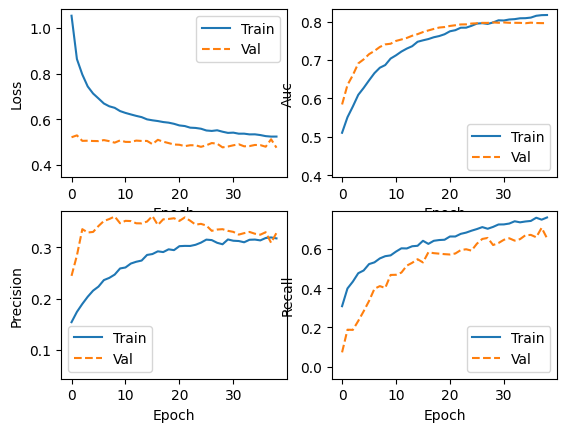

63/63 [==============================] - 0s 602us/step


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import SquaredHinge, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
        AUC(name="prc", curve="PR"),
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(1, activation="sigmoid", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)


##  Imbalanced Data Handling:
# Class Weight
no_of_features = X_train_np_arr.shape[-1]
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
# total /2.0 to ensure losses for both classes get equal importance
weight_for_yes = (1 / yes_class_count) * (total / 2.0)
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))
output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=10, mode="max", restore_best_weights=True)


model_dnn = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
model_dnn.summary()
train_history = model_dnn.fit(
    X_train_np_arr,
    y_train_np_arr,
    validation_data=(X_valid_np_arr, y_valid_np_arr),
    batch_size=1024,
    epochs=500,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
y_valid_dnn_predicted = model_dnn.predict(X_valid_np_arr, batch_size=8024)
print_auc(train_history, 36)
plot_metrics(train_history, metrics=["loss", "auc", "precision", "recall"])
plot_hist_of_predictions(X_train_np_arr, y_train_np_arr, X_valid_np_arr, model_dnn)


In [ ]:
print_auc(train_history, 31)
# print_auc(train_history, 97)
# print_auc(train_history, 113)

Training AUC at epoch 31 :  0.8050799369812012
Validation AUC at epoch 31 :  0.7989698648452759


##### 4.5.1 DNN with smote
- Because we are using class_weights, smote is observed to have not much positive impact on the model performance improvement

Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
Training AUC at epoch 50 :  0.8006989359855652
Validation AUC at epoch 50 :  0.7903397083282471


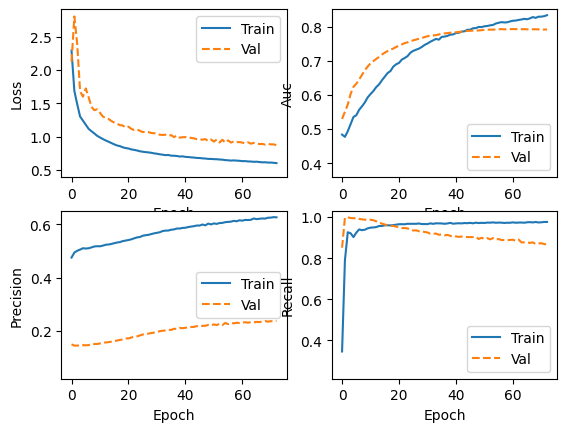

In [12]:
model_smote = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
train_history_smote = model_smote.fit(X_train_smote_np_arr, y_train_smote_np_arr,          
          validation_data=(X_valid_np_arr, y_valid_np_arr),
          batch_size=8024, epochs=500, callbacks=[early_stopping], class_weight=class_weight,
          verbose=0
          )
print_auc(train_history_smote, 50)
plot_metrics(train_history_smote, metrics=['loss', 'auc', 'precision', 'recall'])

##### 4.5.2 NN: Model comparision : Plot ROC / AUPRC
- Comparing nn model with class weights vs without class weights and smote


Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
1/1 [==============================] - 0s 22ms/step


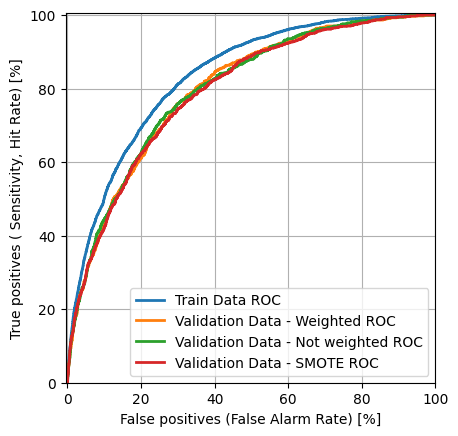

In [16]:
model_dnn_no_weight = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
model_dnn_no_weight.fit(
    X_train_np_arr,
    y_train_np_arr,
    validation_data=(X_valid_np_arr, y_valid_np_arr),
    batch_size=1024,
    epochs=500,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
y_train_dnn_predicted = model_dnn.predict(X_train_np_arr, batch_size=8024)
y_valid_dnn_predicted_no_weight = model_dnn_no_weight.predict(X_valid_np_arr, batch_size=8024)
y_valid_dnn_predicted_smote = model_smote.predict(X_valid_np_arr, batch_size=8024)

# asdasdas
plot_roc("Train Data ROC", y_train, y_train_dnn_predicted)
plot_roc("Validation Data - Weighted ROC", y_valid, y_valid_dnn_predicted)
plot_roc("Validation Data - Not weighted ROC", y_valid, y_valid_dnn_predicted_no_weight)
plot_roc("Validation Data - SMOTE ROC", y_valid, y_valid_dnn_predicted_smote)
plt.legend(loc='lower right')
# plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')


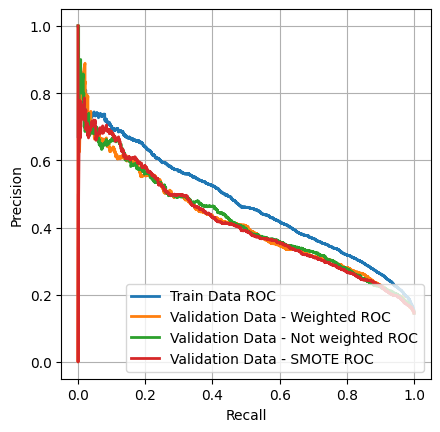

In [17]:
plot_prc("Train Data ROC", y_train, y_train_dnn_predicted)
plot_prc("Validation Data - Weighted ROC", y_valid, y_valid_dnn_predicted)
plot_prc("Validation Data - Not weighted ROC", y_valid, y_valid_dnn_predicted_no_weight)
plot_prc("Validation Data - SMOTE ROC", y_valid, y_valid_dnn_predicted_smote)
plt.legend(loc='lower right')


##### 4.5.2 DNN with Categorical Cross-entropy:
- We transformed the binary representation of (0/1) into dummy representation [0,1] and trained with categorical cross-entropy loss.

Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]
Restoring model weights from the end of the best epoch: 520.
Epoch 570: early stopping


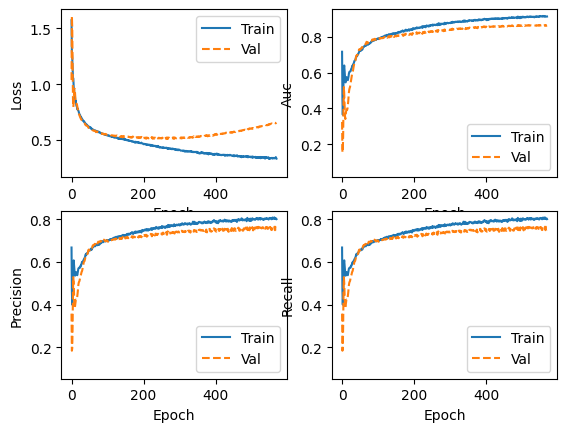

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import (
    SquaredHinge,
    BinaryCrossentropy,
    SparseCategoricalCrossentropy,
    CategoricalCrossentropy,
)
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(2, activation="softmax", name="predictions", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        #   loss=BinaryCrossentropy(),
        loss=CategoricalCrossentropy(),
        metrics=METRICS,
    )
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)
y_train_np_arr_cross_entropy = tf.one_hot(y_train_np_arr, depth=2)
y_valid_np_arr_cross_entropy = tf.one_hot(y_valid_np_arr, depth=2)
y_train_np_arr_cross_entropy = tf.reshape(y_train_np_arr_cross_entropy, [y_train_np_arr_cross_entropy.shape[0], 2])
y_valid_np_arr_cross_entropy = tf.reshape(y_valid_np_arr_cross_entropy, [y_valid_np_arr_cross_entropy.shape[0], 2])


##  Imbalanced Data Handling:
# Class Weight
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
weight_for_yes = (1 / yes_class_count) * (total / 2.0) # total /2.0 to ensure losses for both classes get equal importance
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))

output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=50, mode="max", restore_best_weights=True)

no_of_features = X_train_np_arr.shape[-1]
model_dnn_cross_entropy = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
# model_dnn.summary()
train_history_cross_entropy = model_dnn_cross_entropy.fit(
    X_train_np_arr,
    y_train_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
plot_metrics(train_history_cross_entropy, metrics=["loss", "auc", "precision", "recall"])


In [ ]:
print_auc(train_history_cross_entropy, 40)
print_auc(train_history_cross_entropy, 100)
print_auc(train_history_cross_entropy, 150)
print_auc(train_history_cross_entropy, 200)
print_auc(train_history_cross_entropy, 300)
print_auc(train_history_cross_entropy, 520)

Training AUC at epoch 40 :  0.6878107786178589
Validation AUC at epoch 40 :  0.6944988965988159
Training AUC at epoch 100 :  0.7890141010284424
Validation AUC at epoch 100 :  0.7880125641822815
Training AUC at epoch 150 :  0.8195477724075317
Validation AUC at epoch 150 :  0.8033628463745117
Training AUC at epoch 200 :  0.8444867134094238
Validation AUC at epoch 200 :  0.8188111186027527
Training AUC at epoch 300 :  0.8759604692459106
Validation AUC at epoch 300 :  0.8374991416931152
Training AUC at epoch 520 :  0.911932647228241
Validation AUC at epoch 520 :  0.8620663285255432


### 4.6 Final Model Selection :  Deep Neural Networks
- Based on the AUc score on the Evaluation Dataset, we selected two models
    - Model 1: Logistic Regression : 
            - Validation AUC  :  0.7
    - Model 2: NN(1 hidden layer with class weighting and output layer bias applied) - without SMOTE Data Balancing
        - AUC Score :  
            - Training AUC at epoch 479    :  0.91
            - Validation AUC at epoch 479 :  0.86

1/1 [==============================] - 0s 17ms/step


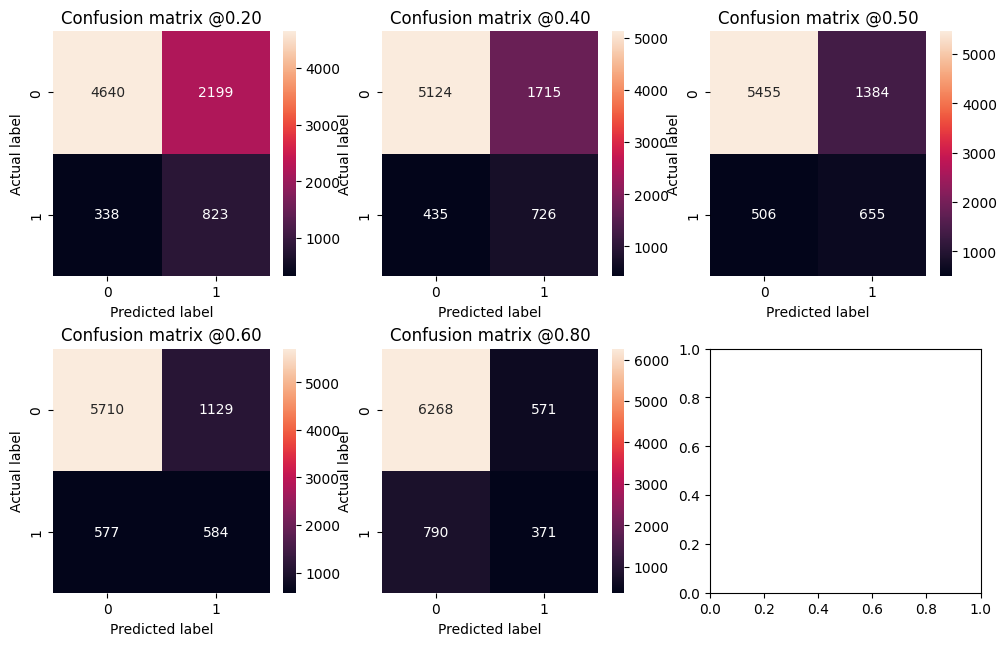

In [ ]:
y_train_predicted_crossentropy = model_dnn_cross_entropy.predict(X_train_np_arr, batch_size=8024)
y_valid_predicted_crossentropy = model_dnn_cross_entropy.predict(X_valid_np_arr, batch_size=8024)
y_train_predicted_one_class = tf.gather(y_train_predicted_crossentropy, [1], axis=1)
y_train_predicted_one_class

y_valid_predicted_one_class = tf.gather(y_valid_predicted_crossentropy, [1], axis=1)
y_valid_predicted_one_class


# plot_cm(y_valid, y_valid_predicted_one_class, 0.5)
# plot_cm(y_valid, y_valid_predicted_one_class, 0.16)

plot_cm_at_intervals(y_valid, y_valid_predicted_one_class, p_intervals=[0.2, 0.4, 0.5, 0.6, 0.8], n_cols=3)



#### 4.6.1 Final Model : Decision Boundary
- By tweaking the decision boundary we can get higher recall or precision. 
- The optimal decision boundary depends on the business use case. In some cases we want comparatively higher recall e.g telemarketing while in other cases i.e disease detection (hiv), we want comparatively higher precision. We do not want to classify a person as having HIV, when in fact he does not.
- However if we are on general looking for a balance between Sensitivity and Specificity. We can use Roc curves and the  geometric mean.
    

Best Threshold=0.19295956194400787, G-Mean=0.6941778323155504


0.19295956

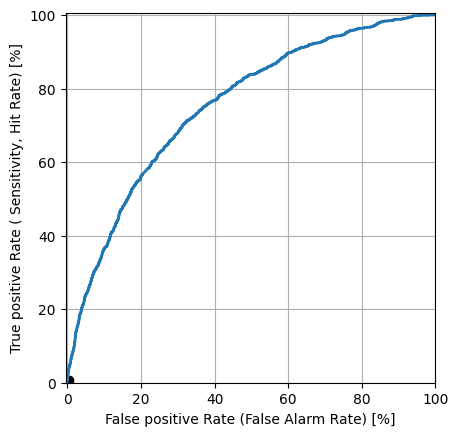

In [ ]:
from numpy import sqrt, argmax

def get_best_threshold_with_best_balance_of_sensitivity_and_specificity(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)  
  plt.xlabel('False positive Rate (False Alarm Rate) [%]')
  plt.ylabel('True positive Rate ( Sensitivity, Hit Rate) [%]')  
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

  # Geometirc Mean to get optimisd point that has right balance between sensitivity and specificity
  gmeans = sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = argmax(gmeans)
  print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  return thresholds[ix]


get_best_threshold_with_best_balance_of_sensitivity_and_specificity("Validation Data", y_valid_np_arr, y_valid_predicted_one_class)

#### 4.6.2 Final Model DNN :  Write Prediction
- We will write DNN output for test file to csv now

Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping
2/2 [==============================] - 0s 3ms/step
Output File Written at Data/nonglmresults.csv


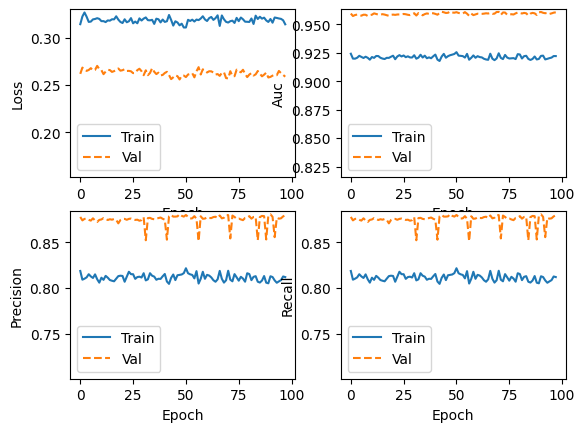

In [ ]:
feature_columns = list(train_df.columns)
feature_columns.remove("y")
X_all = train_df[feature_columns]
y_all = train_df["y"]


X_all_np_array = np.array(X_all)
y_all_np_array = np.array(y_all)
y_all_np_arr_cross_entropy = tf.one_hot(y_all_np_array, depth=2)

train_history_cross_entropy_all = model_dnn_cross_entropy.fit(
    X_all_np_array,
    y_all_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
test_df_predicted_crossentropy = model_dnn_cross_entropy.predict(test_df, batch_size=8024)
test_df_predicted_one_class = tf.gather(test_df_predicted_crossentropy, [1], axis=1)
write_yes_probability_to_a_file(test_df_predicted_crossentropy, "Data/nonglmresults.csv")
print("Output File Written at Data/nonglmresults.csv")

plot_metrics(train_history_cross_entropy_all, metrics=["loss", "auc", "precision", "recall"])


## 5. Model Comparision : LogisticRegression vs DNN
- We will plot the predicitons from Logistic Regression and DNN and compare them

Text(0.5, 1.0, 'NN - Prediction on TestData')

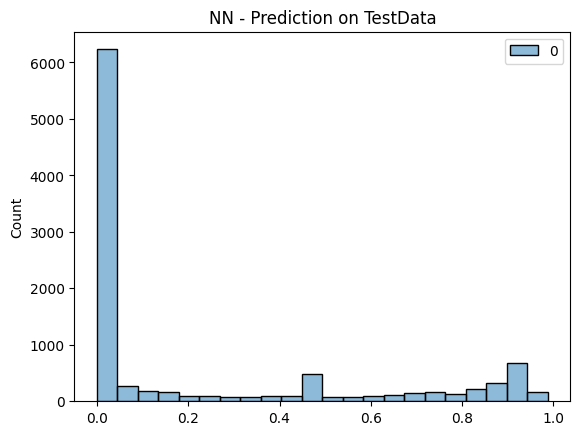

In [ ]:
sns.histplot(test_df_predicted_one_class).set_title("NN - Prediction on TestData")

10000


Text(0.5, 1.0, 'Logistic Regression - Prediction TestData')

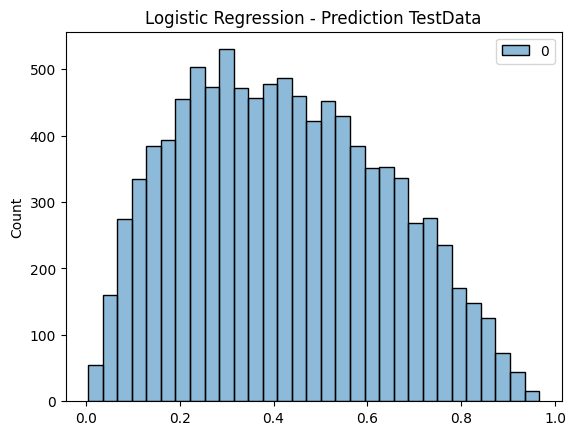

In [ ]:
glmresults = pd.read_csv("Data/glmresults.csv", header=None)
print(len(glmresults))
sns.histplot(glmresults).set_title("Logistic Regression - Prediction TestData")
